# **Introduction**

The way we are visualising the interactions in a recommender system is using a bipartite graph with the users and movies as nodes, and edges between them indicating user-item interactions (features). Those interactions could user user-orientated interactions like ratings, tags for the movie, or even users watching the movie. There are also movie-oriented interactions such as budget, profit etc. This graph representation enables us to employ GNN models - Light Convolutional Neural Network(Light GCN) Neural Graph Collaborative Filtering(NGCF) and evaluate their performance.


# **Step 1: Setting up environment**


In [50]:
%%capture
!pip install torch_geometric
!pip install recommenders[examples]
!pip install recommenders

#@title Setting up environment
!sudo rm -rf /usr/local/lib/python3.8/dist-packages/OpenSSL
!sudo rm -rf /usr/local/lib/python3.8/dist-packages/pyOpenSSL-22.1.0.dist-info/

!wget https://repo.anaconda.com/miniconda/Miniconda3-py38_23.5.2-0-Linux-x86_64.sh
!chmod +x Miniconda3-py38_23.5.2-0-Linux-x86_64.sh

!bash ./Miniconda3-py38_23.5.2-0-Linux-x86_64.sh -b -f -p /usr/local
import sys
sys.path.append('/usr/local/lib/python3.8/site-packages/')
!pip3 install pyOpenSSL==22.0.0

In [51]:
# Standard library imports
from google.colab import drive
import os
import random
import time

# Third-party imports
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
import torch_geometric
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import degree

from tqdm.notebook import tqdm
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
import scipy.sparse as sp

from sklearn.datasets import make_classification
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

from recommenders.datasets.python_splitters import python_stratified_split

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE

In [52]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [53]:
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/BT4222 Project')
os.chdir('Datasets/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Step 2: Importing Dataset**

In [54]:
# Import train and test data from CSV
pre_train_df = pd.read_csv('train_reduced.csv')
pre_test_df = pd.read_csv('test_reduced.csv')

Splitting of dataset to 10% of the test size to decrease testing time

In [55]:
combined_df = pd.concat([pre_train_df, pre_test_df], axis=0)
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 809723 entries, 0 to 187767
Data columns (total 48 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   userId                                       809723 non-null  int64  
 1   rating                                       809723 non-null  float64
 2   timestamp_rated                              809723 non-null  object 
 3   tag                                          7472 non-null    object 
 4   ml_title                                     809723 non-null  object 
 5   tmdbId                                       809723 non-null  int64  
 6   cast                                         809656 non-null  object 
 7   crew                                         809722 non-null  object 
 8   keywords                                     806007 non-null  object 
 9   original_title                               809723 non-nul

In [56]:
unique_users = combined_df['userId'].unique()

half_users = pd.Series(unique_users).sample(frac=0.1, random_state=1).tolist()

combined_df = combined_df[combined_df['userId'].isin(half_users)]

##combined_df.info()

In [57]:
train_df, test_df = python_stratified_split(combined_df, ratio=0.75, col_user="userId", col_item="tmdbId", seed=42)

In [58]:
print(list(train_df.columns))

['userId', 'rating', 'timestamp_rated', 'tag', 'ml_title', 'tmdbId', 'cast', 'crew', 'keywords', 'original_title', 'overview', 'production_companies', 'release_date', 'runtime', 'status', 'tagline', 'movie_id', 'overview_embedding', 'production_country_Germany', 'production_country_United Kingdom', 'production_country_United States of America', 'genre_Action', 'genre_Adventure', 'genre_Animation', 'genre_Children', 'genre_Comedy', 'genre_Crime', 'genre_Drama', 'genre_Family', 'genre_Fantasy', 'genre_Horror', 'genre_Mystery', 'genre_Romance', 'genre_Sci-Fi', 'genre_ScienceFiction', 'genre_Thriller', 'genre_War', 'spoken_language_Deutsch', 'spoken_language_Español', 'spoken_language_Français', 'spoken_language_Italiano', 'has_homepage', 'gross_profit', 'roi', 'profit_margin', 'tagline_sentiment_score_average', 'overview_sentiment_score_average', 'release_year']


In [59]:
train_df.head(5)

,userId,rating,timestamp_rated,tag,ml_title,tmdbId,cast,crew,keywords,original_title,...,spoken_language_Español,spoken_language_Français,spoken_language_Italiano,has_homepage,gross_profit,roi,profit_margin,tagline_sentiment_score_average,overview_sentiment_score_average,release_year
549,346,5.0,2000-12-09 02:35:28,NaN,"Sound of Music, The (1965)",15121,"Julie Andrews, Christopher Plummer, Eleanor Pa...","Robert Wise, Robert Wise, Boris Leven, Richard...","resistance, austria, world war ii, musical, mu...",The Sound of Music,...,0,1,1,0,278014286.0,33.904181,0.971350,0.5848,0.041667,1965
546,346,4.0,2000-12-09 02:50:45,NaN,Rob Roy (1995),11780,"Liam Neeson, Jessica Lange, John Hurt, Tim Rot...","Carter Burwell, Peter Honess, Karl Walter Lind...","scotland, biography, 18th century, highlands, ...",Rob Roy,...,0,0,0,0,3596911.0,0.128461,0.113837,0.4375,-0.401650,1995
552,346,1.0,2000-12-09 02:37:53,NaN,Little Shop of Horrors (1986),10776,"Rick Moranis, Ellen Greene, Vincent Gardenia, ...","Roy Walker, Margery Simkin, John Jympson, Fran...","flower, solar eclipse, florist, assistant, pla...",Little Shop of Horrors,...,0,0,0,0,13748395.0,0.549936,0.354812,0.0000,-0.087514,1986
1643,346,3.0,2000-12-09 02:51:44,NaN,Force 10 from Navarone (1978),17339,"Harrison Ford, Robert Shaw, Barbara Bach, Edwa...","Guy Hamilton, Alistair MacLean, Robin Chapman","gun, traitor, nazis, bridge, major, colonel, b...",Force 10 from Navarone,...,1,0,0,0,2230000.0,0.446000,0.308437,0.0000,0.150000,1978
1655,346,4.0,2000-12-09 02:50:17,NaN,"Last of the Mohicans, The (1992)",9361,"Daniel Day-Lewis, Madeleine Stowe, Russell Mea...","Arthur Schmidt, Michael Mann, Michael Mann, Mi...","secret love, mohawk, native american, 18th cen...",The Last of the Mohicans,...,0,1,0,0,35505856.0,0.887646,0.470240,0.3412,-0.111967,1992


In [60]:
print("Train Size  : ", len(train_df))
print("Test Size : ", len(test_df))

Train Size  :  58923
Test Size :  19646


As not all users and movies may be present in the training set, we will relabel all of users and items to ensure the highest label is the number of users and items, respectively.

In [61]:
le_user = pp.LabelEncoder()
le_item = pp.LabelEncoder()
train_df['user_id_idx'] = le_user.fit_transform(train_df['userId'].values)
train_df['movie_id_idx'] = le_item.fit_transform(train_df['tmdbId'].values)

In [62]:
train_user_ids = train_df['userId'].unique()
train_movie_ids = train_df['tmdbId'].unique()

print(len(train_user_ids), len(train_movie_ids))

test_df = test_df[
  (test_df['userId'].isin(train_user_ids)) & \
  (test_df['tmdbId'].isin(train_movie_ids))
]
print(len(test_df))

866 3118
19502


In [63]:
test_df['user_id_idx'] = le_user.transform(test_df['userId'].values)
test_df['movie_id_idx'] = le_item.transform(test_df['tmdbId'].values)

<ipython-input-63-e3b960519eb9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['user_id_idx'] = le_user.transform(test_df['userId'].values)
<ipython-input-63-e3b960519eb9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['movie_id_idx'] = le_item.transform(test_df['tmdbId'].values)


### Minibatch Sampling

We need to add `n_user` to the sampled positive and negative movies, since each node must have a unique id when using PyG.

In [64]:
n_users = train_df['user_id_idx'].nunique()
n_movies = train_df['movie_id_idx'].nunique()
print("Number of Unique Users : ", n_users)
print("Number of unique Movies : ", n_movies)

Number of Unique Users :  866
Number of unique Movies :  3118


In [65]:
def data_loader(data, batch_size, n_usr, n_itm):

    def sample_neg(x):
        while True:
            neg_id = random.randint(0, n_itm - 1)
            if neg_id not in x:
                return neg_id

    interected_items_df = data.groupby('user_id_idx')['movie_id_idx'].apply(list).reset_index()
    indices = [x for x in range(n_usr)]

    if n_usr < batch_size:
        users = [random.choice(indices) for _ in range(batch_size)]
    else:
        users = random.sample(indices, batch_size)
    users.sort()
    users_df = pd.DataFrame(users,columns = ['users'])

    interected_items_df = pd.merge(interected_items_df, users_df, how = 'right', left_on = 'user_id_idx', right_on = 'users')
    pos_items = interected_items_df['movie_id_idx'].apply(lambda x : random.choice(x)).values
    neg_items = interected_items_df['movie_id_idx'].apply(lambda x: sample_neg(x)).values

    return (
        torch.LongTensor(list(users)).to(device),
        torch.LongTensor(list(pos_items)).to(device) + n_usr,
        torch.LongTensor(list(neg_items)).to(device) + n_usr
    )

data_loader(train_df, 16, n_users, n_movies)

(tensor([ 29,  43,  67, 177, 401, 433, 508, 576, 607, 616, 648, 685, 698, 707,
         746, 816], device='cuda:0'),
 tensor([1708, 2112, 3785,  912, 2877, 1964, 1170, 2789, 1370, 1253, 1325, 1379,
         1803,  945, 1075, 2179], device='cuda:0'),
 tensor([3550, 3606, 2107, 3053, 2534, 2965, 2264, 3145, 2549, 1829, 1931, 1421,
         1469, 1965, 1582, 3762], device='cuda:0'))

## Edge Index

PyG represents graphs as sparse lists of node pairs. Since our graph is undirected, we need to include each edge twice, once for the edges from the users to the items and vice-versa.

Similar to above, we add n_users to the item tensor to ensure that every node in the graph has a unique identifier.

In [66]:
u_t = torch.LongTensor(train_df['user_id_idx'].to_numpy())
i_t = torch.LongTensor(train_df['movie_id_idx'].to_numpy()) + n_users

train_edge_index = torch.stack((
  torch.cat([u_t, i_t]),
  torch.cat([i_t, u_t])
)).to(device)
train_edge_index

tensor([[   0,    0,    0,  ..., 1460, 2096, 3513],
        [3090, 2789, 2569,  ...,  865,  865,  865]], device='cuda:0')

In [67]:
train_edge_index[:,-1], train_edge_index[:, 0]


(tensor([3513,  865], device='cuda:0'), tensor([   0, 3090], device='cuda:0'))

In [68]:
train_edge_index[:, len(train_df)-1], train_edge_index[:, len(train_df)]

(tensor([ 865, 3513], device='cuda:0'), tensor([3090,    0], device='cuda:0'))

# **Step 3: Model Architecture**

### LightGCN Convolutional Layer

In [69]:
class LightGCNConv(MessagePassing):
  def __init__(self, **kwargs):
    super().__init__(aggr='add')

  def forward(self, x, edge_index):
    # Compute normalization
    from_, to_ = edge_index
    deg = degree(to_, x.size(0), dtype=x.dtype)
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
    norm = deg_inv_sqrt[from_] * deg_inv_sqrt[to_]

    # Start propagating messages (no update after aggregation)
    return self.propagate(edge_index, x=x, norm=norm)

  def message(self, x_j, norm):
    return norm.view(-1, 1) * x_j

In [70]:
#testing of LightGCN
test_x = torch.Tensor(np.eye(5))
test_edge_index = torch.LongTensor(np.array([
  [0, 0, 1, 1, 2, 3, 3, 4],
  [2, 3, 3, 4, 0, 0, 1, 1]
]))

LightGCNConv()(test_x, test_edge_index)

tensor([[0.0000, 0.0000, 0.7071, 0.5000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.5000, 0.7071],
        [0.7071, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.7071, 0.0000, 0.0000, 0.0000]])

### NGCF Layer

In [71]:
class NGCFConv(MessagePassing):
  def __init__(self, latent_dim, dropout, bias=True, **kwargs):
    super(NGCFConv, self).__init__(aggr='add', **kwargs)

    self.dropout = dropout

    self.lin_1 = nn.Linear(latent_dim, latent_dim, bias=bias)
    self.lin_2 = nn.Linear(latent_dim, latent_dim, bias=bias)

    self.init_parameters()


  def init_parameters(self):
    nn.init.xavier_uniform_(self.lin_1.weight)
    nn.init.xavier_uniform_(self.lin_2.weight)


  def forward(self, x, edge_index):
    # Compute normalization
    from_, to_ = edge_index
    deg = degree(to_, x.size(0), dtype=x.dtype)
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
    norm = deg_inv_sqrt[from_] * deg_inv_sqrt[to_]

    # Start propagating messages
    out = self.propagate(edge_index, x=(x, x), norm=norm)

    # Perform update after aggregation
    out += self.lin_1(x)
    out = F.dropout(out, self.dropout, self.training)
    return F.leaky_relu(out)


  def message(self, x_j, x_i, norm):
    return norm.view(-1, 1) * (self.lin_1(x_j) + self.lin_2(x_j * x_i))

We will be using the following class, `RecSysGNN` in order to stack the NGCF or LightGCN convolutional layers

In [72]:
class RecSysGNN(nn.Module):
  def __init__(
      self,
      latent_dim,
      num_layers,
      num_users,
      num_items,
      model, # 'NGCF' or 'LightGCN'
      dropout=0.1 # Only used in NGCF
  ):
    super(RecSysGNN, self).__init__()

    assert (model == 'NGCF' or model == 'LightGCN'), \
        'Model must be NGCF or LightGCN'
    self.model = model
    self.embedding = nn.Embedding(num_users + num_items, latent_dim)

    if self.model == 'NGCF':
      self.convs = nn.ModuleList(
        NGCFConv(latent_dim, dropout=dropout) for _ in range(num_layers)
      )
    else:
      self.convs = nn.ModuleList(LightGCNConv() for _ in range(num_layers))

    self.init_parameters()


  def init_parameters(self):
    if self.model == 'NGCF':
      nn.init.xavier_uniform_(self.embedding.weight, gain=1)
    else:
      # Authors of LightGCN report higher results with normal initialization
      nn.init.normal_(self.embedding.weight, std=0.1)


  def forward(self, edge_index):
    emb0 = self.embedding.weight
    embs = [emb0]

    emb = emb0
    for conv in self.convs:
      emb = conv(x=emb, edge_index=edge_index)
      embs.append(emb)

    out = (
      torch.cat(embs, dim=-1) if self.model == 'NGCF'
      else torch.mean(torch.stack(embs, dim=0), dim=0)
    )

    return emb0, out


  def encode_minibatch(self, users, pos_items, neg_items, edge_index):
    emb0, out = self(edge_index)
    return (
        out[users],
        out[pos_items],
        out[neg_items],
        emb0[users],
        emb0[pos_items],
        emb0[neg_items]
    )

# **Step 4: Loss function and metrics**

We implement both the Bayesian Personalized Ranking loss function for a single minibatch of users, positive items, and negative items, as well as the precision@K and recall@K metrics.

In [73]:
def compute_bpr_loss(users, users_emb, pos_emb, neg_emb, user_emb0,  pos_emb0, neg_emb0):
  # compute loss from initial embeddings, used for regulization
  reg_loss = (1 / 2) * (
    user_emb0.norm().pow(2) +
    pos_emb0.norm().pow(2)  +
    neg_emb0.norm().pow(2)
  ) / float(len(users))

  # compute BPR loss from user, positive item, and negative item embeddings
  pos_scores = torch.mul(users_emb, pos_emb).sum(dim=1)
  neg_scores = torch.mul(users_emb, neg_emb).sum(dim=1)

  bpr_loss = torch.mean(F.softplus(neg_scores - pos_scores))

  return bpr_loss, reg_loss

In [74]:
def get_metrics(user_Embed_wts, item_Embed_wts, n_users, n_items, train_data, test_data, K):
    test_user_ids = torch.LongTensor(test_data['user_id_idx'].unique())
    # compute the score of all user-item pairs
    relevance_score = torch.matmul(user_Embed_wts, torch.transpose(item_Embed_wts, 0, 1))

    # create dense tensor of all user-item interactions
    i = torch.stack((
        torch.LongTensor(train_data['user_id_idx'].values),
        torch.LongTensor(train_data['movie_id_idx'].values)
    ))
    v = torch.ones((len(train_data)), dtype=torch.float64)
    interactions_t = torch.sparse_coo_tensor(i, v, (n_users, n_items))\
        .to_dense().to(device)

    # mask out training user-item interactions from metric computation
    relevance_score = torch.mul(relevance_score, (1 - interactions_t))

    # compute top scoring items for each user
    _, topk_relevance_indices = torch.topk(relevance_score, K)
    topk_relevance_indices_df = pd.DataFrame(topk_relevance_indices.cpu().numpy(), columns=['top_indx_' + str(x + 1) for x in range(K)])
    topk_relevance_indices_df['user_ID'] = topk_relevance_indices_df.index
    topk_relevance_indices_df['top_rlvnt_itm'] = topk_relevance_indices_df[['top_indx_' + str(x + 1) for x in range(K)]].values.tolist()
    topk_relevance_indices_df = topk_relevance_indices_df[['user_ID', 'top_rlvnt_itm']]

    # measure overlap between recommended (top-scoring) and held-out user-item interactions
    test_interacted_items = test_data.groupby('user_id_idx')['movie_id_idx'].apply(list).reset_index()
    metrics_df = pd.merge(test_interacted_items, topk_relevance_indices_df, how='left', left_on='user_id_idx',
                          right_on=['user_ID'])
    metrics_df['intrsctn_itm'] = [list(set(a).intersection(b)) for a, b in
                                    zip(metrics_df.movie_id_idx, metrics_df.top_rlvnt_itm)]

    metrics_df['recall'] = metrics_df.apply(lambda x: len(x['intrsctn_itm']) / len(x['movie_id_idx']), axis=1)
    metrics_df['precision'] = metrics_df.apply(lambda x: len(x['intrsctn_itm']) / K, axis=1)

    # Function to calculate DCG@K
    def dcg_at_k(r, k):
        r = np.asfarray(r)[:k]
        return np.sum(r / np.log2(np.arange(2, r.size + 2)))

    # Function to calculate IDCG@K
    def idcg_at_k(r, k):
        sorted_r = sorted(r, reverse=True)
        return dcg_at_k(sorted_r, k)

    # Calculate NDCG@K for each user
    metrics_df['ndcg'] = metrics_df.apply(lambda x: dcg_at_k(x['intrsctn_itm'], K) / idcg_at_k(x['movie_id_idx'], K) if idcg_at_k(x['movie_id_idx'], K) > 0 else 0, axis=1)

    return metrics_df['recall'].mean(), metrics_df['precision'].mean(),  metrics_df['ndcg'].mean()


# **Step 5: Train and evaluate models**


In [75]:
latent_dim = 64
n_layers = 3

EPOCHS = 10
BATCH_SIZE = 1024
DECAY = 0.0001
LR = 0.005
K = 10

In [79]:
def train_and_eval(model, optimizer, train_df):
  loss_list_epoch = []
  bpr_loss_list_epoch = []
  reg_loss_list_epoch = []

  recall_list = []
  precision_list = []

  for epoch in tqdm(range(EPOCHS)):
      n_batch = int(len(train_df)/BATCH_SIZE)

      final_loss_list = []
      bpr_loss_list = []
      reg_loss_list = []

      model.train()
      for batch_idx in range(n_batch):

          optimizer.zero_grad()

          users, pos_items, neg_items = data_loader(train_df, BATCH_SIZE, n_users, n_movies)
          users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0 = model.encode_minibatch(users, pos_items, neg_items, train_edge_index)

          bpr_loss, reg_loss = compute_bpr_loss(
            users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0
          )
          reg_loss = DECAY * reg_loss
          final_loss = bpr_loss + reg_loss

          final_loss.backward()
          optimizer.step()

          final_loss_list.append(final_loss.item())
          bpr_loss_list.append(bpr_loss.item())
          reg_loss_list.append(reg_loss.item())

      model.eval()
      with torch.no_grad():
          _, out = model(train_edge_index)
          final_user_Embed, final_item_Embed = torch.split(out, (n_users, n_movies))
          test_topK_recall,  test_topK_precision, ndcg = get_metrics(
            final_user_Embed, final_item_Embed, n_users, n_movies, train_df, test_df, K
          )

      loss_list_epoch.append(round(np.mean(final_loss_list),4))
      bpr_loss_list_epoch.append(round(np.mean(bpr_loss_list),4))
      reg_loss_list_epoch.append(round(np.mean(reg_loss_list),4))

      recall_list.append(round(test_topK_recall,4))
      precision_list.append(round(test_topK_precision,4))

  return (
    loss_list_epoch,
    bpr_loss_list_epoch,
    reg_loss_list_epoch,
    recall_list,
    precision_list,
    ndcg
  )

### Train and eval LightGCN

In [77]:
lightgcn = RecSysGNN(
  latent_dim=latent_dim,
  num_layers=n_layers,
  num_users=n_users,
  num_items=n_movies,
  model='LightGCN'
)
lightgcn.to(device)

optimizer = torch.optim.Adam(lightgcn.parameters(), lr=LR)
print("Size of Learnable Embedding : ", [x.shape for x in list(lightgcn.parameters())])

Size of Learnable Embedding :  [torch.Size([3984, 64])]


In [80]:
light_loss, light_bpr, light_reg, light_recall, light_precision, light_ndcg = train_and_eval(lightgcn, optimizer, train_df)

  0%|          | 0/10 [00:00<?, ?it/s]

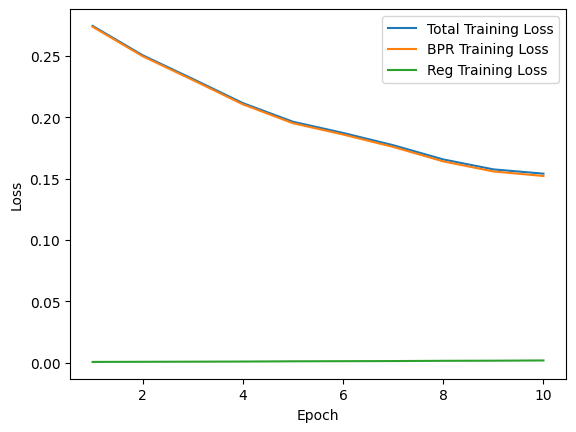

In [81]:
epoch_list = [(i+1) for i in range(EPOCHS)]

plt.plot(epoch_list, light_loss, label='Total Training Loss')
plt.plot(epoch_list, light_bpr, label='BPR Training Loss')
plt.plot(epoch_list, light_reg, label='Reg Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

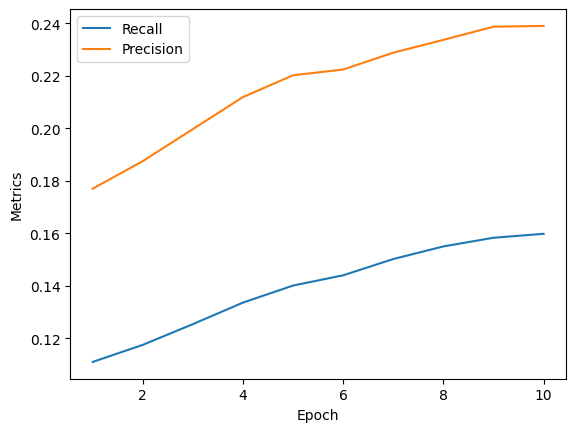

In [82]:
plt.plot(epoch_list, light_recall, label='Recall')
plt.plot(epoch_list, light_precision, label='Precision')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()

### Train and evaluate NGCF

In [83]:
ngcf = RecSysGNN(
  latent_dim=latent_dim,
  num_layers=n_layers,
  num_users=n_users,
  num_items=n_movies,
  model='NGCF'
)
ngcf.to(device)

optimizer = torch.optim.Adam(ngcf.parameters(), lr=LR)
print("Size of Learnable Embedding : ", [x.shape for x in list(ngcf.parameters())])

Size of Learnable Embedding :  [torch.Size([3984, 64]), torch.Size([64, 64]), torch.Size([64]), torch.Size([64, 64]), torch.Size([64]), torch.Size([64, 64]), torch.Size([64]), torch.Size([64, 64]), torch.Size([64]), torch.Size([64, 64]), torch.Size([64]), torch.Size([64, 64]), torch.Size([64])]


In [84]:
ngcf_loss, ngcf_bpr, ngcf_reg, ngcf_recall, ngcf_precision,  ngcf_ndcg= train_and_eval(ngcf, optimizer, train_df)

  0%|          | 0/10 [00:00<?, ?it/s]

In [85]:
epoch_list = [(i+1) for i in range(EPOCHS)]

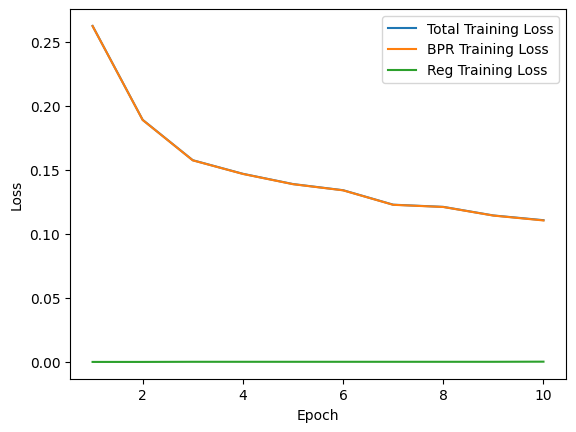

In [86]:
plt.plot(epoch_list, ngcf_loss, label='Total Training Loss')
plt.plot(epoch_list, ngcf_bpr, label='BPR Training Loss')
plt.plot(epoch_list, ngcf_reg, label='Reg Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

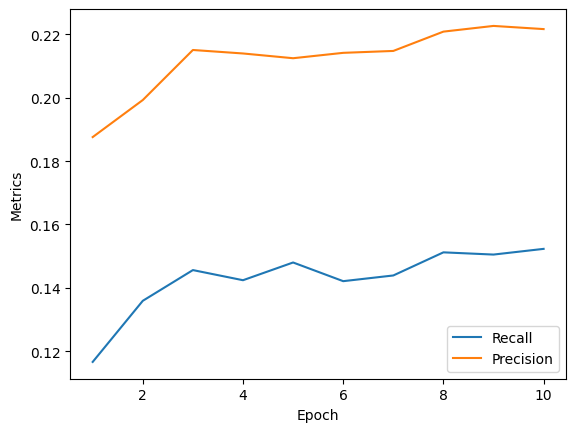

In [87]:
plt.plot(epoch_list, ngcf_recall, label='Recall')
plt.plot(epoch_list, ngcf_precision, label='Precision')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()

### Compare model performance

In [88]:
light_avg_precision = np.mean(light_precision)
light_avg_recall = np.mean(light_recall)


In [90]:
NGCF_avg_precision = np.mean(ngcf_precision)
NGCF_avg_recall = np.mean(ngcf_recall)

In [91]:
def calculate_f1_score(avg_precision, avg_recall):
    return 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall)

f1_score_light = calculate_f1_score(light_avg_precision, light_avg_recall)
f1_score_ngcf= calculate_f1_score(NGCF_avg_precision, NGCF_avg_recall)

In [93]:
print('Light GCN average precision: ' + str(light_avg_precision))
print('Light GCN average recall: ' + str(light_avg_recall))
print(f"F1 Score of Light GCN: {f1_score_light}")
print(f"NDCG Score of Light GCN: {light_ndcg}")
print("")
print('NGCF average precision: ' + str(NGCF_avg_precision))
print('NGCF average recall: ' + str(NGCF_avg_recall))
print(f"F1 Score NGCF: {f1_score_ngcf}")
print(f"NDCG Score of NGCF: {ngcf_ndcg}")

Light GCN average precision: 0.21589
Light GCN average recall: 0.13949
F1 Score of Light GCN: 0.16947772018684223
NDCG Score of Light GCN: 0.11693393685755574

NGCF average precision: 0.21227999999999997
NGCF average recall: 0.14285
F1 Score NGCF: 0.1707780136851294
NDCG Score of NGCF: 0.14759536355895964


# **Step 6: Testing the model with Principal Component Analysis(PCA)**

PCA is used for linear dimensionality reduction. It reduces the dimensionality of data while retaining as much variability as possible. It works by identifying the directions (principal components) in which the data varies the most. It then projects the data onto these directions to reduce its dimensions.

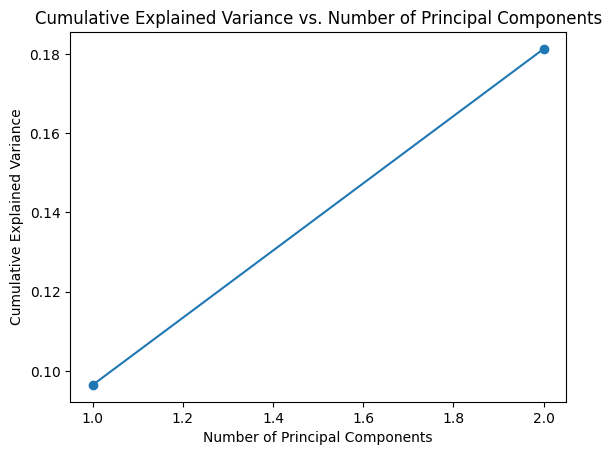

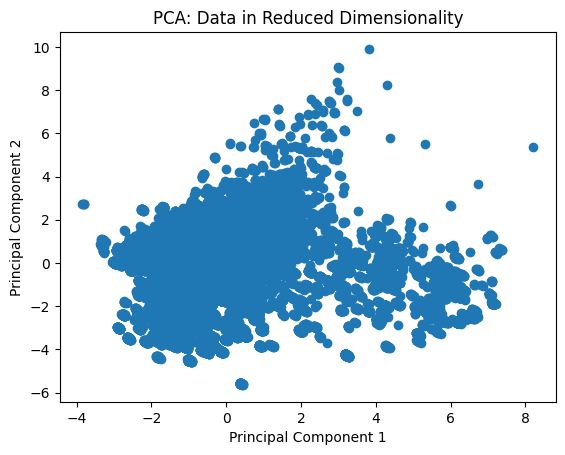

In [94]:
# Assuming train_df has 'user_id_idx' and 'movie_id_idx' columns
df = train_df.drop(['timestamp_rated','tag', 'ml_title',  'cast', 'crew', 'keywords',
                        'original_title', 'overview','production_companies', 'release_date', 'status', 'tagline','overview_embedding'], axis=1)

# Standardize the data (important for PCA)
scaler = StandardScaler()
df.replace([np.inf, -np.inf], np.nan, inplace=True)
data_scaled = scaler.fit_transform(df)

# Impute missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
data_imputed = imputer.fit_transform(data_scaled)

# Apply PCA
n_components = 2  # Number of principal components
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(data_imputed)

# Create a DataFrame for visualization
columns = [f'PC{i+1}' for i in range(n_components)]
df_pca = pd.DataFrame(data=principal_components, columns=columns)

# Add 'user_id_idx' and 'movie_id_idx' back to df_pca
df_pca[['user_id_idx', 'movie_id_idx']] = train_df[['user_id_idx', 'movie_id_idx']].reset_index(drop=True)

# Percentage of variance explained by each principal component
explained_variance_ratio = pca.explained_variance_ratio_

# Plot the cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
plt.plot(range(1, n_components + 1), cumulative_explained_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Principal Components')
plt.show()

# Plot the data in the new PCA space
plt.scatter(df_pca['PC1'], df_pca['PC2'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: Data in Reduced Dimensionality')
plt.show()

In [97]:
PCA_light_loss, PCA_light_bpr, PCA_light_reg, PCA_light_recall, PCA_light_precision, PCA_light_ndcg = train_and_eval(lightgcn, optimizer, df_pca)

PCA_light_avg_precision = np.mean(PCA_light_precision)
PCA_light_avg_recall = np.mean(PCA_light_recall)


  0%|          | 0/10 [00:00<?, ?it/s]

In [98]:
PCA_ngcf_loss, PCA_ngcf_bpr, PCA_ngcf_reg, PCA_ngcf_recall, PCA_ngcf_precision, PCA_ngcf_ndcg= train_and_eval(ngcf, optimizer, df_pca)

PCA_ngcf_avg_precision = np.mean(PCA_ngcf_precision)
PCA_ngcf_avg_recall = np.mean(PCA_ngcf_recall)



  0%|          | 0/10 [00:00<?, ?it/s]

In [99]:
f1_score_light_PCA = calculate_f1_score(PCA_light_avg_precision, PCA_light_avg_recall)
f1_score_ngcf_PCA = calculate_f1_score(PCA_ngcf_avg_precision, PCA_ngcf_avg_recall)




In [100]:
print('Light GCN(PCA) average precision: ' + str(PCA_light_avg_precision))
print('Light GCN(PCA) average recall: ' + str(PCA_light_avg_recall))
print(f"F1 Score of Light GCN(PCA): {f1_score_light_PCA}")
print(f"NDCG Score of Light GCN(PCA): {PCA_light_ndcg}")
print("")
print('NGCF(PCA) average precision: ' + str(PCA_ngcf_avg_precision))
print('NGCF(PCA) average recall: ' + str(PCA_ngcf_avg_recall))
print(f"F1 Score NGCF(PCA): {f1_score_ngcf_PCA}")
print(f"NDCG Score of NGCF(PCA): {PCA_ngcf_ndcg}")

Light GCN(PCA) average precision: 0.23899999999999996
Light GCN(PCA) average recall: 0.1598
F1 Score of Light GCN(PCA): 0.1915356068204614
NDCG Score of Light GCN(PCA): 0.11693393685755574

NGCF(PCA) average precision: 0.22291
NGCF(PCA) average recall: 0.15043
F1 Score NGCF(PCA): 0.17963438849306262
NDCG Score of NGCF(PCA): 0.12918107367226625


# **Step 7: Testing the model with TSNE**

T-SNE is used for nonlinear dimensionality reduction and is particularly good at visualizing high-dimensional datasets. It works by converting similarities between data points to joint probabilities and trying to minimize the divergence between these joint probabilities in the high-dimensional and low-dimensional space.

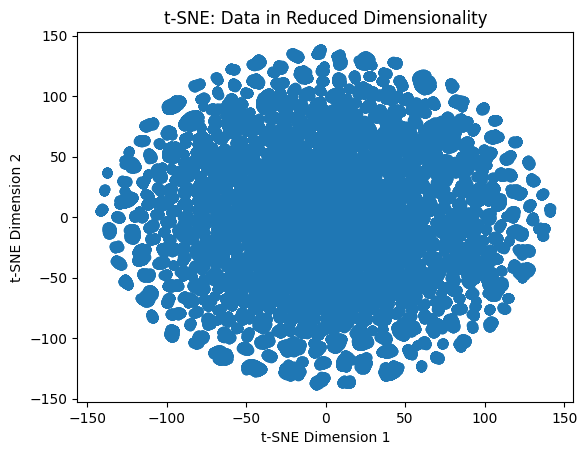

In [101]:
# Assuming train_df has 'user_id_idx' and 'movie_id_idx' columns
df = train_df.drop(['timestamp_rated','tag', 'ml_title',  'cast', 'crew', 'keywords',
                        'original_title', 'overview','production_companies', 'release_date', 'status', 'tagline','overview_embedding'], axis=1)

# Standardize the data (important for t-SNE)
scaler = StandardScaler()
df.replace([np.inf, -np.inf], np.nan, inplace=True)
data_scaled = scaler.fit_transform(df)

# Impute missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
data_imputed = imputer.fit_transform(data_scaled)

# Apply t-SNE
n_components = 2  # Number of components (2 for visualization)
tsne = TSNE(n_components=n_components, random_state=42)
embedded_data = tsne.fit_transform(data_imputed)

# Create a DataFrame for visualization
columns = [f'Dim{i+1}' for i in range(n_components)]
df_tsne = pd.DataFrame(data=embedded_data, columns=columns)

# Add 'user_id_idx' and 'movie_id_idx' back to df_tsne
df_tsne[['user_id_idx', 'movie_id_idx']] = train_df[['user_id_idx', 'movie_id_idx']].reset_index(drop=True)

# Plot the data in the t-SNE space
plt.scatter(df_tsne['Dim1'], df_tsne['Dim2'])
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE: Data in Reduced Dimensionality')
plt.show()

In [102]:
TSNE_light_loss, TSNE_light_bpr, TSNE_light_reg, TSNE_light_recall, TSNE_light_precision, TSNE_light_ndcg = train_and_eval(lightgcn, optimizer, df_tsne)

TSNE_light_avg_precision = np.mean(TSNE_light_precision)
TSNE_light_avg_recall = np.mean(TSNE_light_recall)

  0%|          | 0/10 [00:00<?, ?it/s]

In [103]:
TSNE_ngcf_loss, TSNE_ngcf_bpr, TSNE_ngcf_reg, TSNE_ngcf_recall, TSNE_ngcf_precision, TSNE_ngcf_ndcg = train_and_eval(ngcf, optimizer, df_tsne)

TSNE_ngcf_avg_precision = np.mean(TSNE_ngcf_precision)
TSNE_ngcf_avg_recall = np.mean(TSNE_ngcf_recall)



  0%|          | 0/10 [00:00<?, ?it/s]

In [104]:
f1_score_light_TSNE = calculate_f1_score(TSNE_light_avg_precision, TSNE_light_avg_recall)
f1_score_ngcf_TSNE = calculate_f1_score(TSNE_ngcf_avg_precision, TSNE_ngcf_avg_recall)



In [106]:
print('Light GCN(TSNE) average precision: ' + str(TSNE_light_avg_precision))
print('Light GCN(TSNE) average recall: ' + str(TSNE_light_avg_recall))
print(f"F1 Score of Light GCN(TSNE): {f1_score_light_TSNE}")
print(f"NDCG Score of Light GCN(PCA): {TSNE_light_ndcg}")
print("")
print('NGCF(PCA) average precision: ' + str(TSNE_ngcf_avg_precision))
print('NGCF(PCA) average recall: ' + str(TSNE_ngcf_avg_recall))
print(f"F1 Score NGCF(TSNE): {f1_score_ngcf_TSNE}")
print(f"NDCG Score of Light GCN(PCA): {TSNE_ngcf_ndcg}")

Light GCN(TSNE) average precision: 0.23899999999999996
Light GCN(TSNE) average recall: 0.1598
F1 Score of Light GCN(TSNE): 0.1915356068204614
NDCG Score of Light GCN(PCA): 0.11693393685755574

NGCF(PCA) average precision: 0.23479999999999998
NGCF(PCA) average recall: 0.16147999999999998
F1 Score NGCF(TSNE): 0.191357141415161
NDCG Score of Light GCN(PCA): 0.1343942461523352


# Code References:

1. https://www.kaggle.com/dipanjandas96/lightgcn-pytorch-from-scratch

2. https://github.com/gusye1234/LightGCN-PyTorch

3. https://github.com/SytzeAndr/NGCF_RP32/blob/hand-in/NGCF.ipynb

4. https://medium.com/stanford-cs224w/recommender-systems-with-gnns-in-pyg-d8301178e377